In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy import interpolate
import pickle

matplotlib.rcParams['legend.fontsize'] = 60
matplotlib.rcParams['axes.labelpad'] = 0
matplotlib.rcParams['axes.linewidth'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.labelsize'] = 75
matplotlib.rcParams['xtick.labelsize'] = 65 
matplotlib.rcParams['ytick.labelsize'] = 65
matplotlib.axis.YAxis.OFFSETTEXTPAD = 25

## In this notebook we plot the position of the BAO peak as a function of redshift for the bestfit model parameters

### Load in the best-fit data

In [2]:
fn_006 = '../bestfit/mnu_006.bestfit'
fn_009 = '../bestfit/mnu_009.bestfit'
fn_012 = '../bestfit/mnu_012.bestfit'
fn_015 = '../bestfit/mnu_015.bestfit'
fn_018 = '../bestfit/mnu_018.bestfit'
fn_024 = '../bestfit/mnu_024.bestfit'
fn_03 = '../bestfit/mnu_03.bestfit'
fn_lcdm = '../bestfit/LCDM.bestfit'


In [3]:
bfs_dict={}

In [4]:
#save the lcdm data in a dictionary 
with open(fn_lcdm) as f:
    bfs_dict['lcdm'] = {}
    for line in f: 
        if line.split()[0] == '#':
            print(len(line.split()))
            names = [line.split()[k].replace(',', '') for k in range(1,62)]
        else: 
            vals = line.split()

    for j in range(len(vals)):
        bfs_dict['lcdm'][names[j]] = vals[j]


62


In [5]:
fns = [fn_006,fn_009,fn_012,fn_015,fn_018,fn_024,fn_03]
mnus= [6,9,12,15,18,24,30]


In [6]:
i=0
for fn in fns: 
    with open(fn) as f:
        bfs_dict[f'{mnus[i]}'] = {}
        for line in f: 
            if line.split()[0] == '#':
                names = [line.split()[k].replace(',', '') for k in range(1,65)]
            else: 
                vals = line.split()
                
        for j in range(len(vals)):
            bfs_dict[f'{mnus[i]}'][names[j]] = vals[j]

    i+=1

65
65
65
65
65
65
65


In [7]:
#function for loading in bestfit data 
def load_obj(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    

In [8]:
mnu_006_dict= bfs_dict['6']
mnu_012_dict= bfs_dict['12']
mnu_018_dict= bfs_dict['18']
mnu_024_dict= bfs_dict['24']
mnu_03_dict= bfs_dict['30']
mnu_015_dict= bfs_dict['15']
mnu_009_dict= bfs_dict['9']
lcdm_dict = bfs_dict['lcdm']

In [9]:
#BEST FIT PARAMS FROM BF with LCDM model  
LCDM_settings = {'output':'tCl pCl lCl mPk', 
                 '100*theta_s': lcdm_dict['100*theta_s'],
                 'ln10^{10}A_s': lcdm_dict['ln10^{10}A_s'],
                 'n_s': lcdm_dict['n_s'],
                 'omega_b':  float(lcdm_dict['omega_b']),
                 'omega_cdm': lcdm_dict['omega_cdm'],
                 'tau_reio': lcdm_dict['tau_reio'],
                 'l_max_scalars':3508,
                 'non linear':'HMcode',
                 'P_k_max_h/Mpc':30,
                 'Omega_Lambda':0,                      
                 'Omega_fld':0,                         
                 'Omega_scf': -1,                        #scf
                 'scf_parameters':'1, 1, 1, 1, 1, 0.0', #scf
                 'scf_tuning_index':3,                  #scf
                 'attractor_ic_scf':'no',               #scf
                 'n_scf':3,                             #scf
                 'CC_scf':1,                            #scf
                 'f_scf': np.power(10,26.59913),        #scf                              
                 'm_scf': 0,                            #scf: this guarantees fEDE is 0 (otherwise hard to force)
                 'thetai_scf': 2.83,        
                 'z_max_pk':2.}

In [10]:
LCDM = Class()
LCDM.set(LCDM_settings)
LCDM.compute()

In [11]:
EDE_fiducial_params= {'H0': 72.19,
         'log10z_c': 3.562,
         'thetai_scf': 2.83,
         'ln10^{10}A_s': np.log(22.15),
         'n_s': 0.9889,
         'omega_b': 0.0253,
         'omega_cdm': 0.12999,
         'tau_reio': 0.0511,
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.,
         'fEDE': 0.122}


EDE_pp_bf_params= {'100*theta_s': mnu_006_dict['100*theta_s'],
         'log10z_c': mnu_006_dict['log10z_c'],
         'thetai_scf': mnu_006_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_006_dict['ln10^{10}A_s'],
         'n_s': mnu_006_dict['n_s'],
         'omega_b':  float(mnu_006_dict['omega_b']),
         'omega_cdm': mnu_006_dict['omega_cdm'],
         'tau_reio': mnu_006_dict['tau_reio'],
         'fEDE': mnu_006_dict['fEDE'],
         'N_ncdm':1,
         'm_ncdm': 0.06,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.}


EDE_mnu_03_pp_bf_params= {'100*theta_s': mnu_03_dict['100*theta_s'],
         'log10z_c': mnu_03_dict['log10z_c'],
         'thetai_scf': mnu_03_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_03_dict['ln10^{10}A_s'],
         'n_s': mnu_03_dict['n_s'],
         'omega_b':  float(mnu_03_dict['omega_b']),
         'omega_cdm': mnu_03_dict['omega_cdm'],
         'tau_reio': mnu_03_dict['tau_reio'],
         'fEDE': mnu_03_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.3,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 


EDE_mnu_018_pp_bf_params= {'100*theta_s': mnu_018_dict['100*theta_s'],
         'log10z_c': mnu_018_dict['log10z_c'],
         'thetai_scf': mnu_018_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_018_dict['ln10^{10}A_s'],
         'n_s': mnu_018_dict['n_s'],
         'omega_b':  float(mnu_018_dict['omega_b']),
         'omega_cdm': mnu_018_dict['omega_cdm'],
         'tau_reio': mnu_018_dict['tau_reio'],
         'fEDE': mnu_018_dict['fEDE'],
         'non linear':'HMCODE',
         'N_ncdm':1,
         'm_ncdm': 0.18,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 


EDE_mnu_024_pp_bf_params= {'100*theta_s': mnu_024_dict['100*theta_s'],
         'log10z_c': mnu_024_dict['log10z_c'],
         'thetai_scf': mnu_024_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_024_dict['ln10^{10}A_s'],
         'n_s': mnu_024_dict['n_s'],
         'omega_b':  float(mnu_024_dict['omega_b']),
         'omega_cdm': mnu_024_dict['omega_cdm'],
         'tau_reio': mnu_024_dict['tau_reio'],
         'fEDE': mnu_024_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.24,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_015_pp_bf_params= {'100*theta_s': mnu_015_dict['100*theta_s'],
         'log10z_c': mnu_015_dict['log10z_c'],
         'thetai_scf': mnu_015_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_015_dict['ln10^{10}A_s'],
         'n_s': mnu_015_dict['n_s'],
         'omega_b':  float(mnu_015_dict['omega_b']),
         'omega_cdm': mnu_015_dict['omega_cdm'],
         'tau_reio': mnu_015_dict['tau_reio'],
         'fEDE': mnu_015_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.15,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_009_pp_bf_params= {'100*theta_s': mnu_009_dict['100*theta_s'],
         'log10z_c': mnu_009_dict['log10z_c'],
         'thetai_scf': mnu_009_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_009_dict['ln10^{10}A_s'],
         'n_s': mnu_009_dict['n_s'],
         'omega_b':  float(mnu_009_dict['omega_b']),
         'omega_cdm': mnu_009_dict['omega_cdm'],
         'tau_reio': mnu_009_dict['tau_reio'],
         'fEDE': mnu_009_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.09,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

EDE_mnu_012_pp_bf_params= {'100*theta_s': mnu_012_dict['100*theta_s'],
         'log10z_c': mnu_012_dict['log10z_c'],
         'thetai_scf': mnu_012_dict['thetai_scf'],
         'ln10^{10}A_s': mnu_012_dict['ln10^{10}A_s'],
         'n_s': mnu_012_dict['n_s'],
         'omega_b':  float(mnu_012_dict['omega_b']),
         'omega_cdm': mnu_012_dict['omega_cdm'],
         'tau_reio': mnu_012_dict['tau_reio'],
         'fEDE': mnu_012_dict['fEDE'],
         'non linear':'HMCODE',      
         'N_ncdm':1,
         'm_ncdm': 0.12,
         'N_ur':2.0328, 
         'Omega_Lambda':0.0, #set to zero as included in potential function! 
         'Omega_fld':0, 
         'Omega_scf':-1, 
         'n_scf':3, #n-value for potential 
         'CC_scf':1, 
         'scf_parameters':'1, 1, 1, 1, 1, 0.0', 
         'scf_tuning_index':3, 
         'attractor_ic_scf':'no', 
         'output':'tCl pCl lCl mPk', 
         'lensing':'yes', 
         'l_max_scalars':3508, 
         'P_k_max_h/Mpc':30,
         'z_max_pk':2.} 

In [12]:
EDE_fid = Class()
EDE_fid.set(EDE_fiducial_params)
EDE_fid.compute()



In [13]:
EDE_pp = Class()
EDE_pp.set(EDE_pp_bf_params)
EDE_pp.compute()

IOStream.flush timed out


In [14]:
EDE_mnu03 = Class()
EDE_mnu03.set(EDE_mnu_03_pp_bf_params)
EDE_mnu03.compute()


IOStream.flush timed out


In [15]:
EDE_mnu018 = Class()
EDE_mnu018.set(EDE_mnu_018_pp_bf_params)
EDE_mnu018.compute()

In [16]:
EDE_mnu009 = Class()
EDE_mnu009.set(EDE_mnu_009_pp_bf_params)
EDE_mnu009.compute()

In [17]:
EDE_mnu015 = Class()
EDE_mnu015.set(EDE_mnu_015_pp_bf_params)
EDE_mnu015.compute()

In [18]:
EDE_mnu024 = Class()
EDE_mnu024.set(EDE_mnu_024_pp_bf_params)
EDE_mnu024.compute()

In [19]:
EDE_mnu012 = Class()
EDE_mnu012.set(EDE_mnu_012_pp_bf_params)
EDE_mnu012.compute()

In [20]:
h_EDE_mnu03=EDE_mnu03.h()
h_EDE_mnu024 = EDE_mnu024.h()
h_EDE_mnu018 = EDE_mnu018.h()
h_EDE_mnu012 = EDE_mnu012.h()
h_EDE_mnu015 = EDE_mnu015.h()
h_EDE_mnu009 = EDE_mnu009.h()
h_EDE_pp = EDE_pp.h()

In [21]:
sig8_EDE_mnu03 = EDE_mnu03.sigma8()
sig8_EDE_mnu024 = EDE_mnu024.sigma8()
sig8_EDE_mnu018 = EDE_mnu018.sigma8()
sig8_EDE_mnu012 = EDE_mnu012.sigma8()
sig8_EDE_mnu015 = EDE_mnu015.sigma8()
sig8_EDE_mnu009 = EDE_mnu009.sigma8()
sig8_pp = EDE_pp.sigma8()
sig8_EDE_fid = EDE_fid.sigma8()

In [22]:
rs_ede_fid = EDE_fid.rs_drag()
rs_lcdm = LCDM.rs_drag()
rs_ede_pp = EDE_pp.rs_drag()
rs_EDE_mnu03 = EDE_mnu03.rs_drag()
rs_EDE_mnu018 = EDE_mnu018.rs_drag()
rs_EDE_mnu024 = EDE_mnu024.rs_drag()
rs_EDE_mnu012 = EDE_mnu012.rs_drag()
rs_EDE_mnu015 = EDE_mnu015.rs_drag()
rs_EDE_mnu009 = EDE_mnu009.rs_drag()

In [23]:
#Get background quantities and compute the spherically averaged distance 
baLCDM = LCDM.get_background()
baEDE_fid = EDE_fid.get_background()
baEDE_pp = EDE_pp.get_background()
baEDE_mnu03 = EDE_mnu03.get_background()
baEDE_mnu018 = EDE_mnu018.get_background()
baEDE_mnu024 = EDE_mnu024.get_background()
baEDE_mnu012 = EDE_mnu012.get_background()
baEDE_mnu009 = EDE_mnu009.get_background()
baEDE_mnu015 = EDE_mnu015.get_background()

EDE_pp_ang = baEDE_pp['ang.diam.dist.']
LCDM_ang = baLCDM['ang.diam.dist.']
EDE_mnu03_ang = baEDE_mnu03['ang.diam.dist.']
EDE_mnu018_ang = baEDE_mnu018['ang.diam.dist.']
EDE_mnu024_ang = baEDE_mnu024['ang.diam.dist.']
EDE_mnu012_ang = baEDE_mnu012['ang.diam.dist.']
EDE_mnu009_ang = baEDE_mnu009['ang.diam.dist.']
EDE_mnu015_ang = baEDE_mnu015['ang.diam.dist.']

z_lcdm = baLCDM['z']
z_ede_pp = baEDE_pp['z']
z_ede_mnu012 = baEDE_mnu012['z']
z_ede_mnu018 = baEDE_mnu018['z']
z_ede_mnu024 = baEDE_mnu024['z']
z_ede_mnu03 = baEDE_mnu03['z']
z_ede_mnu015 = baEDE_mnu015['z']
z_ede_mnu009 = baEDE_mnu009['z']

#Form the spherically averaged D_v  
#Made unitless as we look at ratios anyway 
LCDM_dv = ((((np.ones_like(z_lcdm)+z_lcdm)*LCDM_ang)**2)*z_lcdm/baLCDM['H [1/Mpc]'])**(1/3) 
EDE_pp_dv =((((np.ones_like(z_lcdm)+z_ede_pp)*EDE_pp_ang)**2)*z_ede_pp/baEDE_pp['H [1/Mpc]'])**(1/3)
EDE_mnu012_dv =((((np.ones_like(z_lcdm)+z_ede_mnu012)*EDE_mnu012_ang)**2)*z_ede_mnu012/baEDE_mnu012['H [1/Mpc]'])**(1/3)
EDE_mnu018_dv =((((np.ones_like(z_lcdm)+z_ede_mnu018)*EDE_mnu018_ang)**2)*z_ede_mnu018/baEDE_mnu018['H [1/Mpc]'])**(1/3)
EDE_mnu024_dv =((((np.ones_like(z_lcdm)+z_ede_mnu024)*EDE_mnu024_ang)**2)*z_ede_mnu024/baEDE_mnu024['H [1/Mpc]'])**(1/3)
EDE_mnu03_dv =((((np.ones_like(z_lcdm)+z_ede_mnu03)*EDE_mnu03_ang)**2)*z_ede_mnu03/baEDE_mnu03['H [1/Mpc]'])**(1/3)
EDE_mnu009_dv =((((np.ones_like(z_lcdm)+z_ede_mnu009)*EDE_mnu009_ang)**2)*z_ede_mnu009/baEDE_mnu009['H [1/Mpc]'])**(1/3)
EDE_mnu015_dv =((((np.ones_like(z_lcdm)+z_ede_mnu015)*EDE_mnu015_ang)**2)*z_ede_mnu03/baEDE_mnu015['H [1/Mpc]'])**(1/3)


#This is 1/theta_bao for EDE 
EDE_pp_ratios = EDE_pp_dv/rs_ede_pp
LCDM_ratios = LCDM_dv/rs_lcdm
EDE_mnu03_ratios = EDE_mnu03_dv/rs_EDE_mnu03
EDE_mnu018_ratios = EDE_mnu018_dv/rs_EDE_mnu018
EDE_mnu024_ratios = EDE_mnu024_dv/rs_EDE_mnu024
EDE_mnu012_ratios = EDE_mnu012_dv/rs_EDE_mnu012
EDE_mnu015_ratios = EDE_mnu015_dv/rs_EDE_mnu015
EDE_mnu009_ratios = EDE_mnu009_dv/rs_EDE_mnu009

In [24]:
#making an interpolation to match up the z values for different experiments 
EDE_pp_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_pp),np.flip(EDE_pp_ratios))
EDE_mnu012_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu012),np.flip(EDE_mnu012_ratios))
EDE_mnu018_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu018),np.flip(EDE_mnu018_ratios))
EDE_mnu024_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu024),np.flip(EDE_mnu024_ratios))
EDE_mnu03_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu03),np.flip(EDE_mnu03_ratios))
EDE_mnu009_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu009),np.flip(EDE_mnu009_ratios))
EDE_mnu015_spline = interpolate.InterpolatedUnivariateSpline(np.flip(z_ede_mnu015),np.flip(EDE_mnu015_ratios))

In [25]:
EDE_pp_out = EDE_pp_spline(z_lcdm)
EDE_mnu012_out = EDE_mnu012_spline(z_lcdm)
EDE_mnu018_out = EDE_mnu018_spline(z_lcdm)
EDE_mnu024_out = EDE_mnu024_spline(z_lcdm)
EDE_mnu03_out = EDE_mnu03_spline(z_lcdm)
EDE_mnu009_out = EDE_mnu009_spline(z_lcdm)
EDE_mnu015_out = EDE_mnu015_spline(z_lcdm)

## Add in the BOSS $\theta_{BAO}$ measurements 

In [26]:
#THE BOSS DATA POINTS: 
rd_fid = 147.78 #MPc (fiducial r_d value used in paper)

boss_zs = [0.38,0.51,0.61] #the average redshifts at which the BOSS data is collected 

boss_vals = np.array([1477,1877,2140]) #The average values of D_v * rd_fid/r_d from the BOSS data section 8.2 eqts 21-23 in https://arxiv.org/pdf/1607.03155.pdf

boss_vals = boss_vals/rd_fid

z_038 = np.where((z_lcdm<=0.38) & (z_lcdm>=0.379))[0][0]

z_051 = np.where((z_lcdm<=0.51) & (z_lcdm>=0.509))[0][0]

z_061 = np.where((z_lcdm<=0.61) & (z_lcdm>=0.609))[0][0]

lcdm_reference_vals = np.array([LCDM_ratios[z_038], LCDM_ratios[z_051], LCDM_ratios[z_061]])
boss_ratios = boss_vals/lcdm_reference_vals

print(boss_ratios)

[1.00375075 0.99720699 0.98836493]


### Plot ratio of BAO scales of EDE models to LCDM prediction 

Theta BAO for best-fit models with different neutrino masses (multi-coloured sdahed lines) scaled to LCDM prediction (black-dashed line). BAO position data from BOSS galaxy clustering measurements and associated error-bar shown in purple triangles.  

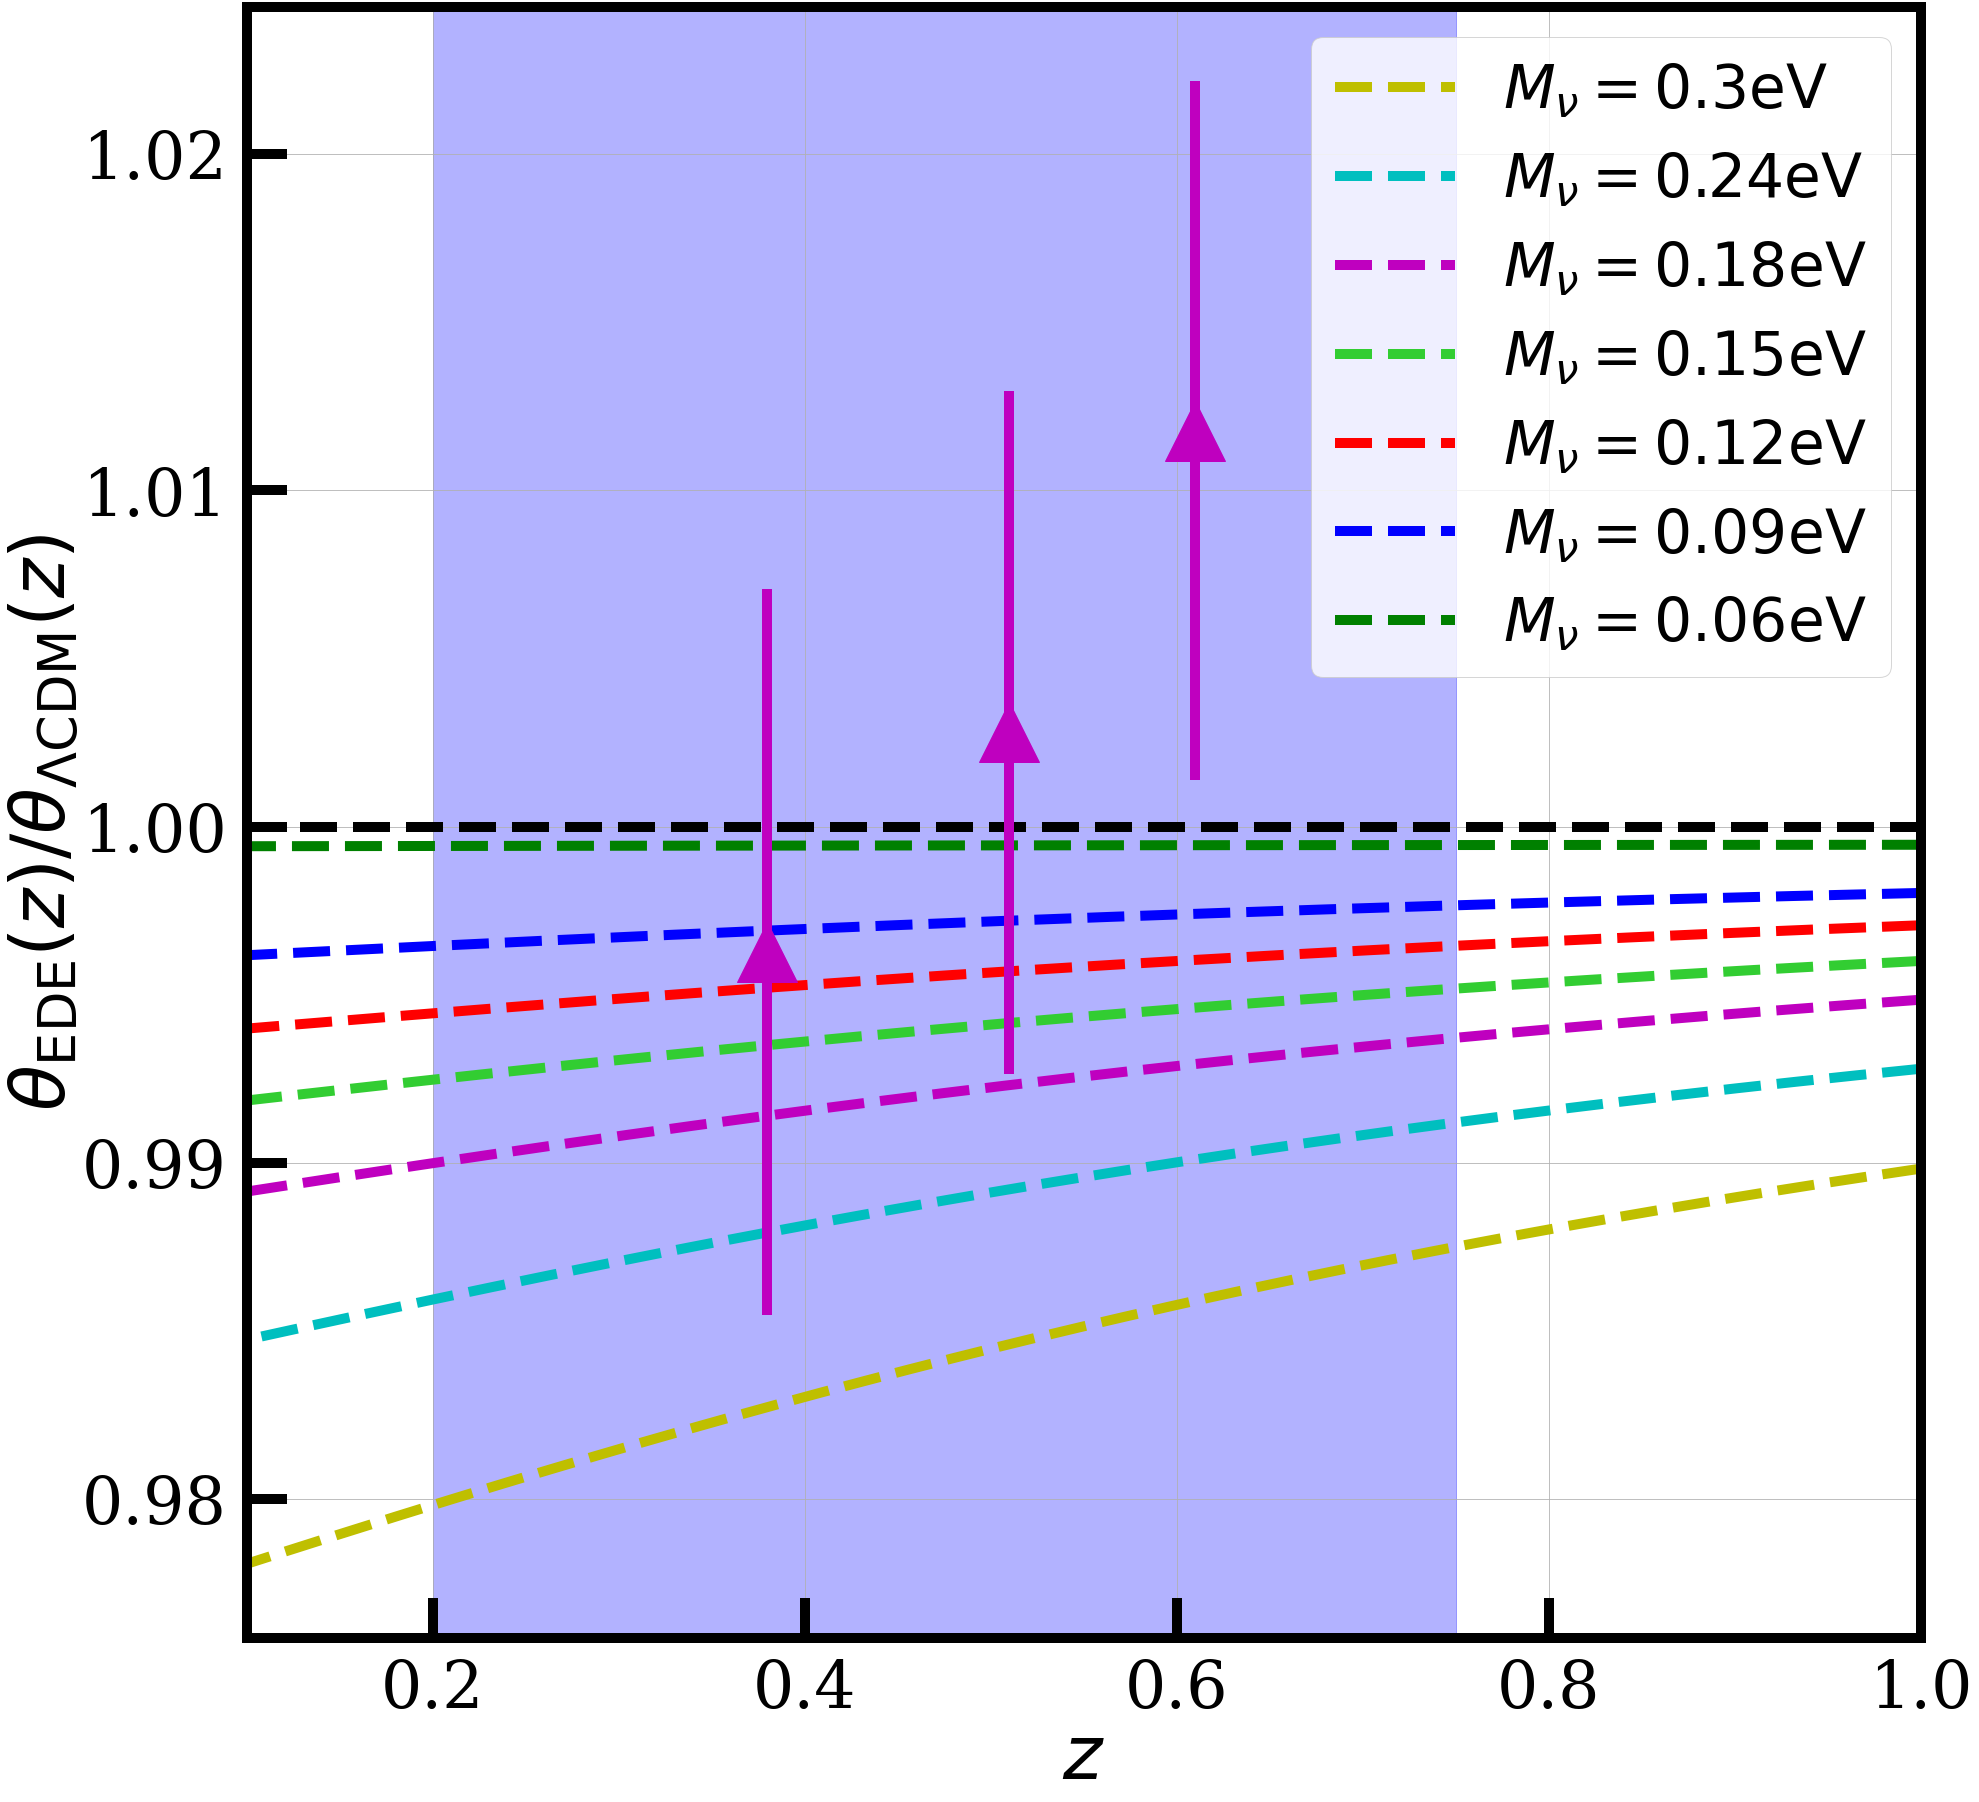

In [27]:
fig, ax1 = plt.subplots(1, 1,figsize=(30,30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
ax1.grid()

zs = z_lcdm[(z_lcdm >= 0.1) & (z_lcdm <= 1)]

ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu03_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'y',ls='--',lw=10,label=  r'$M_\nu=0.3\rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu024_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)],color= 'c',ls='--',lw=10,label=  r'$M_\nu=0.24 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu018_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'm',ls='--',lw=10,label=  r'$M_\nu=0.18 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu015_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'limegreen',ls='--',lw=10,label=  r'$M_\nu=0.15 \rm eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu012_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'r',ls='--',lw=10,label=  r'$M_\nu=\rm 0.12eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_mnu009_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)] ,color= 'b',ls='--',lw=10,label=  r'$M_\nu= \rm 0.09eV$')
ax1.plot(zs,LCDM_ratios[(z_lcdm >= 0.1) & (z_lcdm <= 1)]/EDE_pp_out[(z_lcdm >= 0.1) & (z_lcdm <= 1)],color= 'g',ls='--',lw=10,label= r'$M_\nu= \rm 0.06eV$')

ax1.axhline(1,c='k',lw=10,ls='--')
boss_fractional_err = np.array([(16/rd_fid),(19/rd_fid),(22/rd_fid)])/boss_vals #from the error in the alam paper: https://arxiv.org/pdf/1607.03155.pdf eqts 21-23 in sect. 8.2 consensus BAO + fs results
boss_err = boss_fractional_err * boss_vals**(-1) * lcdm_reference_vals #assume the fractional error in the value of theta is the same as in the value of 1/theta

ax1.errorbar(boss_zs, (boss_ratios)**(-1), yerr=boss_err, fmt='^', color='m', markersize=60, capthick=40,lw=10)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\theta_{\rm EDE}(z)/\theta_{\Lambda{\rm CDM}}(z)$')
ax1.set_xlim(0.1,1.0)

ax1.tick_params(pad=20)
ax1.tick_params(which='major',axis='x', length=40, width=10, direction='in')
ax1.tick_params(which='minor',axis='x', length=25, width=5, direction='in')
ax1.tick_params(which='major',axis='y', length=40, width=10, direction='in')
ax1.tick_params(which='minor',axis='y', length=25, width=5, direction='in')
ax1.legend(loc='best')

ax1.axvspan(0.2, 0.75, alpha=0.3, color='blue')
fig.savefig('BAO_postion_plot.png', bbox_inches='tight')
